In [9]:
!pip install networkx
!pip install requests
!pip install pandas 
!pip install matplotlib
!pip install scipy

  Using cached scipy-1.14.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
Using cached scipy-1.14.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (40.8 MB)


In [2]:
import json
import networkx as nx
import pandas as pd
from metrics.packages_reached_by_vuln import ComputePackagesReachedByVuln
from metrics.clustering_coefficient import ComputeClusteringCoefficient
from metrics.degrees import ComputeOutDegree, ComputeInDegree, ComputeAverageDegree
from metrics.number_of_vul_per_packages import ComputeVulPackagesSucessor
from metrics.percentage_of_the_network_reached_by_set import ComputePctgOftheNetworkReached
from metrics.centralities import BetweennessCentrality, ClosenessCentrality, EigenvectorCentrality,  DegreeCentrality
from metrics.number_of_reachable_packages import ComputeNumOfReachablePkgs
from metrics.longest_path import ComputeLongestPath
from metrics.pagerank import ComputePageRank
from metrics.nodes_and_edges import ComputeNodesAndEdges, ComputeDensity
from graph_builder import build_dependency_graph

# Construção do Grafo

O código a seguir carrega dados de um arquivo JSON (.json`) para criar o grafo e o dicionário de vulnerabilidades, onde as chaves são os nomes dos pacotes em minúsculas e os valores são listas de vulnerabilidades associadas a cada pacote. Em seguida, exibe o nome e as vulnerabilidades de pacotes que possuem vulnerabilidades registradas.

In [3]:
data = json.load(open('dataset.json'))

vulnerability_dict = {
    package['name'].lower(): [vul for vul in package.get('package_vulnerabilities', [])
    if vul and ((vul['aliases'] and '2024' in vul['aliases'][0]))]
    for package in data
}

for vul in vulnerability_dict:
    if len(vulnerability_dict[vul]):
        print(vul, vulnerability_dict[vul])


confidant [{'aliases': ['CVE-2024-45793'], 'details': '### Impact\n_What kind of vulnerability is it? Who is impacted?_\nPotential XSS from API calls below:\nGET <app>/v1/credentials\nGET <app>/v1/credentials/<id>\nGET <app>/v1/archive/credentials/<id>\nGET <app>/v1/archive/credentials\nPOST <app>/v1/credentials\nPUT <app>/v1/credentials/<id>\nPUT <app>/v1/credentials/<id>/<to_revision>\n\nGET <app>/v1/services\nGET <app>/v1/services/<id>\nGET <app>/v1/archive/services/<id>\nGET <app>/v1/archive/services\nPUT <app>/v1/services/<id>\nPUT <app>/v1/services/<id>/<to_revision>\n\nStored XSS that can only be used as a stored HTML injection. The attacker needs to be authenticated and have privileges to create new credentials, but could use this to show information and run scripts to other users into the same Confidant instance.\n\n### Patches\n_Has the problem been patched? What versions should users upgrade to?_\nyes, version 6.6.2\n\n### Workarounds\n_Is there a way for users to fix or rem

In [4]:
packages = {package['name']: package for package in data}
graph = build_dependency_graph(packages, vulnerability_dict)

In [5]:
num_of_nodes, num_of_edges = ComputeNodesAndEdges()(graph)
density = ComputeDensity()(graph)
avarege_degree = ComputeAverageDegree()(graph)
print("Original graph num of nodes:", num_of_nodes)
print("Original graph num of edges:", num_of_edges)
print("Original graph density:", density)

Original graph num of nodes: 567819
Original graph num of edges: 542134
Original graph density: 3.362927963070214e-06


# Redução do grafo

O código faz uma copia do grafo original, remove componentes triviais (nós isolados) e calcula o número de nós, arestas e a densidade do grafo reduzido, exibindo esses resultados no console.

- Interessante notar que o grafo reduziu de 500 mil nós para cerca de 180 mil 

In [6]:
graph_without_trivial_com = graph.copy()
components = nx.weakly_connected_components(graph)
trivial_nodes = [node for component in components if len(component) == 1 for node in component]
graph_without_trivial_com.remove_nodes_from(trivial_nodes)

num_of_nodes, num_of_edges = ComputeNodesAndEdges()(graph_without_trivial_com)
density = ComputeDensity()(graph_without_trivial_com)
avarege_degree = ComputeAverageDegree()(graph_without_trivial_com)
print("num of nodes:", num_of_nodes)
print("num of edges:", num_of_edges)
print("graph density:", density)
print("Avarage degree:", avarege_degree)

num of nodes: 177102
num of edges: 542048
graph density: 3.4563941617543284e-05
Avarage degree: 6.121308624408533


# Lista de pacotes atigindos por vulnerabilidades presentes no grafo

O código a seguir lista informaçõe dos pacotes atigindos por vulnerabilidade no grafo.

In [7]:
pkgs_vul_impact = ComputeVulPackagesSucessor()(graph_without_trivial_com.reverse())

for pkg, vul in sorted(pkgs_vul_impact.items(), key=lambda x: len(x[1]), reverse=True):
    print(f'{pkg} ; {len(vul)} ; {vulnerability_dict[pkg][0]['aliases'][0]}')

python-jose ; 170 ; CVE-2024-33664
djangorestframework-simplejwt ; 37 ; CVE-2024-22513
flair ; 19 ; CVE-2024-10073
xhtml2pdf ; 14 ; CVE-2024-25885
sentry ; 7 ; CVE-2024-41656
text-generation ; 6 ; CVE-2024-3924
dtale ; 2 ; CVE-2024-3408
pyassimp ; 1 ; CVE-2024-48423
mezzanine ; 1 ; CVE-2024-25170
ryu ; 1 ; CVE-2024-28732
confidant ; 0 ; CVE-2024-45793
case-utils ; 0 ; CVE-2024-22194
chuanhuchatgpt ; 0 ; CVE-2024-6035
apache-submarine ; 0 ; CVE-2024-36264
ait-core ; 0 ; CVE-2024-35059
frigate ; 0 ; CVE-2024-32874
temporai ; 0 ; CVE-2024-0936
lollms ; 0 ; CVE-2024-3121


# Lista os Pacotes mais influentes da rede de dependência

In [10]:
num_of_used_by = ComputeNumOfReachablePkgs()(graph_without_trivial_com.reverse())
nodes_in_degree = ComputeInDegree()(graph_without_trivial_com)
nodes_out_degree = ComputeOutDegree()(graph_without_trivial_com)
clossness_centrality = ClosenessCentrality()(graph_without_trivial_com)
page_rank = ComputePageRank()(graph_without_trivial_com)
sorted_pagerank = sorted(page_rank.items(), key=lambda x: x[1], reverse=True)

data = []
for pkg, page_rank in sorted_pagerank[:20]:
    pct_of_network = round(num_of_used_by[pkg] / graph_without_trivial_com.number_of_nodes(), ndigits=4)
    data.append({
        'Node': pkg,
        'PageRank': page_rank,
        'Clossnes_centrality': clossness_centrality[pkg],
        'Num_dependents': num_of_used_by[pkg],
        'Out-Degree': nodes_out_degree[pkg],
        'In-Degree': nodes_in_degree[pkg],
        'Pct_of_Network': pct_of_network * 100    
    })

df = pd.DataFrame(data)

df.head(20)

,Node,PageRank,Clossnes_centrality,Num_dependents,Out-Degree,In-Degree,Pct_of_Network
0,requests,0.036543,0.158584,35228,0,27660,19.89
1,numpy,0.033447,0.190466,41160,0,32755,23.24
2,pandas,0.015896,0.117492,23075,0,20828,13.03
3,matplotlib,0.008914,0.081786,18245,0,13675,10.30
4,scipy,0.008155,0.073400,15587,0,12781,8.80
5,pyyaml,0.008086,0.052900,13269,0,8645,7.49
6,typing-extensions,0.007977,0.034855,14115,0,1673,7.97
7,click,0.007359,0.043946,10112,0,7442,5.71
8,setuptools,0.006894,0.032174,10153,0,4210,5.73
9,beautifulsoup4,0.006321,0.035384,9816,1,5971,5.54


# Lista de possíveis pacotes mais impactados por vulnerabilidades

In [28]:
num_of_dependecies = ComputeNumOfReachablePkgs()(graph_without_trivial_com)
sorted_num_of_dependecies = sorted(num_of_dependecies.items(), key=lambda x: x[1], reverse=True)

data = []

for pkg, num in sorted_num_of_dependecies[:10]:
    longest_path_l, _ = ComputeLongestPath()(graph_without_trivial_com, pkg)
    data.append({
        'Node': pkg,
        'Num_of_dependecies': num,
        'Out-Degree': nodes_out_degree[pkg],
        'In-Degree': nodes_in_degree[pkg],
        'longest_path_length': longest_path_l
    })

df = pd.DataFrame(data)

df.head(20)

,Node,Num_of_dependecies,Out-Degree,In-Degree,longest_path_length
0,superpilot,368,359,0,4
1,cpskin.demo,278,5,0,27
2,brasil.gov.portal,277,71,1,27
3,brasil.gov.temas,277,4,1,28
4,cpskin.policy,273,39,1,26
5,ideabox.policy,253,27,0,26
6,design.plone.iocittadino,238,4,0,28
7,imio.directory.policy,237,15,0,23
8,imio.events.policy,234,15,0,24
9,design.plone.ioprenoto,234,4,0,28


# Grafico do impacto dos top-k nós de acordo com diferentes métricas

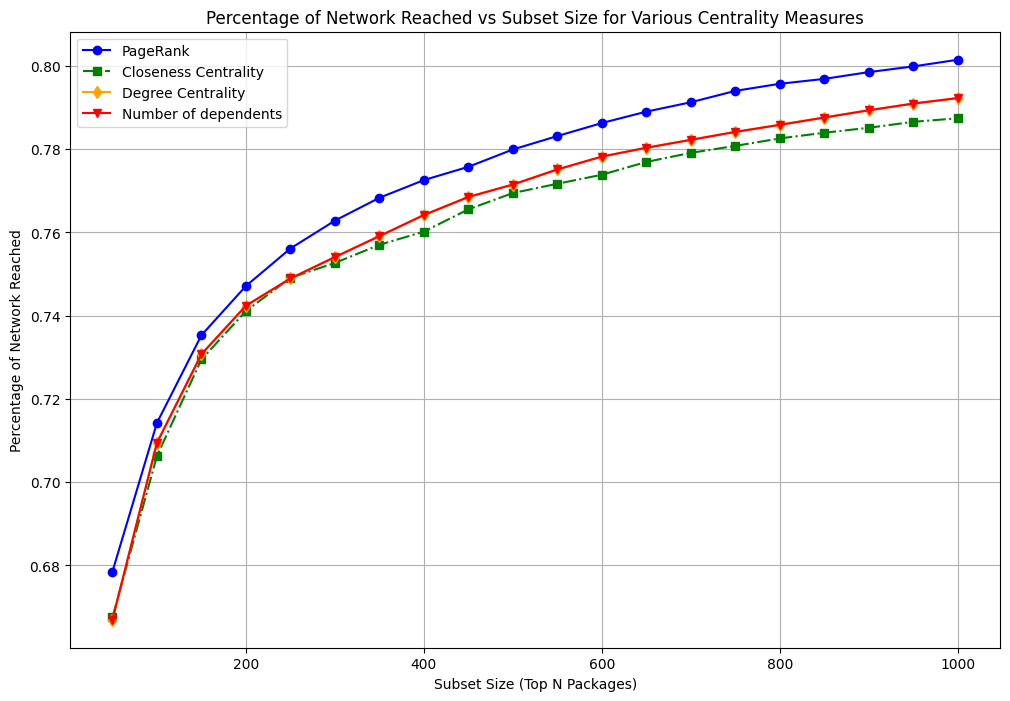

In [ ]:
import matplotlib.pyplot as plt

subset_pagerank = [pkg for pkg, _ in sorted_pagerank[:1000]]
subset_closeness = [pkg for pkg, _ in sorted(clossness_centrality.items(), key=lambda x: x[1], reverse=True)[:1000]]
subset_degree = [pkg for pkg, _ in sorted(nodes_in_degree.items(), key=lambda x: x[1], reverse=True)[:1000]]
subset_used_by = [pkg for pkg, _ in sorted(num_of_used_by.items(), key=lambda x: x[1], reverse=True)[:1000]]

percentages_pagerank = []
percentages_closeness = []
percentages_degree = []
percentages_used_by = []

STEP = 50
compute_pct_network = ComputePctgOftheNetworkReached()

for i in range(1, 21):
    subset_size = i * STEP
    
    percentages_pagerank.append(compute_pct_network(graph_without_trivial_com.reverse(), subset_pagerank[:subset_size]))
    percentages_closeness.append(compute_pct_network(graph_without_trivial_com.reverse(), subset_closeness[:subset_size]))
    percentages_degree.append(compute_pct_network(graph_without_trivial_com.reverse(), subset_degree[:subset_size]))
    percentages_used_by.append(compute_pct_network(graph_without_trivial_com.reverse(), subset_degree[:subset_size]))
    

# Plotting
subset_sizes = [i * STEP for i in range(1, 21)]  # x-axis values (10, 20, ..., 100)

plt.figure(figsize=(12, 8))
plt.plot(subset_sizes, percentages_pagerank, marker='o', color='b', linestyle='-', label="PageRank")
plt.plot(subset_sizes, percentages_closeness, marker='s', color='g', linestyle='-.', label="Closeness Centrality")
plt.plot(subset_sizes, percentages_degree, marker='d', color='orange', linestyle='-', label="Degree Centrality")
plt.plot(subset_sizes, percentages_used_by, marker='v', color='red', linestyle='-', label="Number of dependents")

plt.xlabel("Subset Size (Top N Packages)")
plt.ylabel("Percentage of Network Reached")
plt.title("Percentage of Network Reached vs Subset Size for Various Centrality Measures")
plt.legend()
plt.grid(True)
plt.savefig('images/chart.pdf')
plt.show()

# Cria os arquivos csv para plotar o grafo com o Cosmograph

In [12]:
import networkx as nx

def mark_reachable_nodes(graph: nx.DiGraph, top_10_pagerank: list[str]) -> None:
    """
    Marca os nós alcançáveis a partir dos pacotes de top-10 PageRank.
    Os nós alcançados recebem o atributo 'status' com o nome do pacote que os alcançou.
    Aqueles que não são alcançados por nenhum pacote são marcados como 'não alcançado'.
    
    :param graph: Grafo direcionado
    :param top_10_pagerank: Lista de pacotes com os 10 principais valores de PageRank
    """
    nx.set_node_attributes(graph, 'não alcançado', 'alcançado por')

    def dfs(node, reached_from):
        if graph.nodes[node]['alcançado por'] != 'não alcançado':
            return
        
        graph.nodes[node]['alcançado por'] = reached_from

        for neighbor in graph.successors(node):
            dfs(neighbor, reached_from)

    for pkg in top_10_pagerank:
        if pkg in graph:
            dfs(pkg, pkg)
    
    return graph
reverse_graph_without_trivial_com = mark_reachable_nodes(graph_without_trivial_com.reverse(), subset_pagerank[:10])



In [13]:
import networkx as nx
import csv

def export_graph_to_csv(graph: nx.Graph, nodes_filename: str, edges_filename: str):
    with open(nodes_filename, 'w', newline='', encoding='utf-8') as nodes_file:
        writer = csv.writer(nodes_file)
        writer.writerow(['id', 'alcançado por'])
        
        for node, data in graph.nodes(data=True):
            writer.writerow([node, data.get('alcançado por', 'não disponível')])
    
    with open(edges_filename, 'w', newline='', encoding='utf-8') as edges_file:
        writer = csv.writer(edges_file)
        writer.writerow(['Source', 'Target'])
        
        for source, target in graph.edges():
            writer.writerow([source, target])

export_graph_to_csv(reverse_graph_without_trivial_com, 'csv_files/nodes.csv', 'csv_files/edges.csv')


# Valida o Grafo construido

O processo de validação do grafo busca comparar a contagem de pacotes dependentes calculada localmente através do grafo com os dados provenientes da API do Libraries.io, uma plataforma que fornece informações sobre dependências de pacotes Python. O objetivo é verificar a precisão do número de pacotes dependentes registrado no grafo.

Primeiramente, é feita a extração da contagem de pacotes dependentes do grafo utilizando a função `ComputeNumOfReachablePkgs()`, que calcula o número de pacotes que dependem de um determinado pacote no grafo. Esta contagem é então invertida, ou seja, o grafo é revertido para garantir que as dependências sejam corretamente calculadas. Em seguida, o código seleciona aleatoriamente 200 pacotes do grafo para validação.

A validação ocorre em lotes, com cada lote contendo 40 pacotes. Para cada pacote no lote, é feita uma requisição à API do Libraries.io para obter o número de dependentes desse pacote. A função `get_dependent_packages_from_librariesio` faz a requisição e retorna a contagem de dependentes se a resposta for bem-sucedida (código de status HTTP 200). Caso contrário, é retornado um erro indicando a falha ao obter os dados.

Para cada pacote, o erro absoluto entre a contagem calculada no grafo e a contagem obtida do Libraries.io é calculado pela função `calculate_absolute_error`. O erro absoluto é então registrado em uma lista para cada lote. Para garantir que o processo de validação não sobrecarregue o servidor, é introduzido um atraso de 60 segundos entre cada lote de requisições.

Após a execução da validação para todos os pacotes, o código calcula a mediana e a média dos erros absolutos. A mediana dos erros é usada como uma métrica central para avaliar a precisão geral da construção do grafo, enquanto a média fornece uma visão do erro médio para os pacotes analisados.

In [24]:
import random
import requests
import time
import statistics

def get_dependent_packages_from_librariesio(package_name):
    url = f"https://libraries.io/api/pypi/{package_name}"
    params = {
        'api_key': '8ba1a7bcdf5a2530fffb19abed86fc46',
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()
        return data['dependents_count']
    else:
        print(f"Erro ao obter dados para {package_name}")
        return None

def calculate_absolute_error(computed_count, libraries_io_count):
    return abs(computed_count - libraries_io_count)

num: dict = ComputeNumOfReachablePkgs()(graph_without_trivial_com.reverse())
random_indices = random.sample(list(num.items()), 200)

batch_size = 40
batches = [random_indices[i:i + batch_size] for i in range(0, len(random_indices), batch_size)]

absolute_errors = []

for batch in batches:
    for package, computed_count in batch:
        libraries_io_count = get_dependent_packages_from_librariesio(package)
        
        if libraries_io_count is not None:
            absolute_error = calculate_absolute_error(computed_count, libraries_io_count)
            absolute_errors.append(absolute_error)
    
    time.sleep(60)

# Calcular a mediana dos erros absolutos
median_absolute_error = statistics.median(absolute_errors) if absolute_errors else 0
mean= statistics.mean(absolute_errors)

print(f"Lista de medianas: {absolute_errors}")
print(f"Mediana dos erros absolutos: {median_absolute_error}")
print(f"Erro medio dos pacotes: {mean}")


Lista de medianas: [0, 0, 7, 0, 8, 0, 0, 0, 0, 86, 0, 0, 0, 0, 0, 0, 1, 23, 1, 0, 1, 4, 0, 1, 0, 12, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 2, 0, 0, 166, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 296, 0, 11, 0, 0, 0, 0, 0, 35, 0, 0, 2, 0, 0, 0, 8, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 19, 0, 0, 0, 0, 4, 1, 0, 0, 0, 23, 2, 0, 0, 0, 0, 44, 0, 0, 0, 0, 0, 2046, 68, 0, 2, 0, 4, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 1, 57, 0, 0, 0, 0, 0, 2, 0, 0, 100, 0, 0, 0, 0, 0, 0, 0, 22, 0, 0, 1, 2, 0, 0, 0, 0, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 4, 0, 47, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 8, 0, 0, 1, 3, 0]
Mediana dos erros absolutos: 0.0
Erro medio dos pacotes: 15.775
